# Data Exploration

In [1]:
# Some imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from matplotlib.pyplot import figure

%matplotlib inline

DATA_DIR = "./Data"

In [2]:
image1 = 2000
image2 = 4567

## Images

Each image has been resized to 224px by 224px.

In [3]:
def show_image(image_index, train_set=True):
    """Display image with given index.
    
    Parameters
    ----------
    image_index: int
        Numeric index of the image (max 9999 for train, max 1999 for test).
    train_set: bool (default=True)
        Whether to look in the train or in the test set.
    """
    if train_set:
        dataset = 'train'
    else:
        dataset = 'test'
    image = Image.open(
        os.path.join(DATA_DIR, f'images_{dataset}/{image_index}.jpg'))
    plt.imshow(image)
    plt.show()

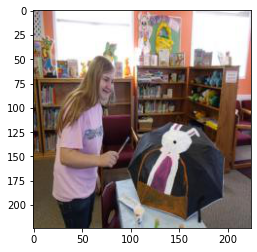

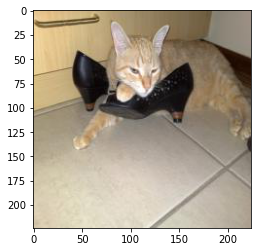

(None, None)

In [13]:
show_image(image1), show_image(image2)

## ResNet Feature Vectors

Each image has 1000 features provided extracted from the penultimate layer of the pretrained ResNet neural network.

In [202]:
def get_feat_matrix(train_set=True):
    """Get feature matrix for given dataset
    
    Parameters
    ----------
    train_set: bool (default=True)
        Whether to look in the train or in the test set.
        
    Returns
    -------
    X: ndarray of shape (n, 1000)
        A matrix containing the ResNet features for the train or test images.
    """
    if train_set:
        dataset = 'train'
    else:
        dataset = 'test'
    feats = pd.read_csv(
        os.path.join(DATA_DIR, f'features_{dataset}/features_resnet1000_{dataset}.csv'),
        names = ['Image']+["X{}".format(i) for i in range(1000)])
    # Need to sort data
    feats["Image"] = feats["Image"].apply(lambda s: int(s.split("/")[1].split(".jpg")[0]))
    feats.sort_values(by="Image", inplace=True)
    X = feats.values[:, 1:]
    return X

## Descriptions 

Each image comes with a series of human given queries (descriptions).

In [111]:
def get_description(image_index, train_set=True):
    """Get description of image with given index.
    
    Parameters
    ----------
    image_index: int
        Numeric index of the image (max 9999 for train, max 1999 for test).
    train_set: bool (default=True)
        Whether to look in the train or in the test set.
        
    Returns
    -------
    description: string
        The description of the image as a paragraph of text with punctuation removed.
    """
    if train_set:
        dataset = 'train'
    else:
        dataset = 'test'
    f = open(
        os.path.join(DATA_DIR, f'descriptions_{dataset}/{image_index}.txt'))
    desc = f.read()
    f.close()
    # Some post-processing 
    desc = desc.replace(".", " ")
    desc = desc.replace("\n", " ")
    return desc

In [112]:
get_description(image2)

'A strawberry blond cat is cuddled up between a pair of ladies business shoes   A cat resting on the floor cuddled up with a pair of heels Orange and white cat laying with its head on some shoes  A very cute orange cat laying with some shoes  a cat rests its head and paw on a pair of womens shoes '

In [12]:
# Download files
import urllib.request
import os

if not os.path.exists("GoogleNews-vectors-negative300.bin.gz"):
    urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", filename="GoogleNews-vectors-negative300.bin.gz")

In [19]:
import gensim

word2vec = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
print("Loaded word vectors successfully!")

Loaded word vectors successfully!


In [113]:
train_desc = [get_description(i) for i in range(10000)]
test_desc = [get_description(i, train_set=False) for i in range(2000)]

In [114]:
def doc_to_vec(sentence, word2vec):
    """Convert text to a 300-dimensional vector
    
    Each word is converted to a vector via the word-to-vec model and the vectors are averaged
    to give the final result.
    
    Parameters
    ----------
    sentence: string
        Text to be converted to a vector.
    word2vec: word2vec model
        Movel to be used for vectorization.
        
    Returns
    -------
    vec: array of shape (300, )
        Vector that represents the average of word2vec-transformed vectors for the given sentence. 
    """
    word_vecs = [word2vec.get_vector(w.lower()) for w in sentence.split() if w.lower() in word2vec.key_to_index]
    # Return average
    return np.stack(word_vecs).mean(0)

In [239]:
X = np.array([doc_to_vec(s, word2vec) for s in train_desc])
X_test = np.array([doc_to_vec(s, word2vec) for s in test_desc])

In [240]:
print("Shape of X:", X.shape)
print("Shape of X_test:", X_test.shape)
print("Done building features!")

Shape of X: (10000, 300)
Shape of X_test: (2000, 300)
Done building features!


In [204]:
Y = get_feat_matrix()
Y_test = get_feat_matrix(train_set=False)

In [205]:
print("Shape of Y:", Y.shape)
print("Shape of Y_test:", Y_test.shape)
print("Done building features!")

Shape of Y: (10000, 1000)
Shape of Y_test: (2000, 1000)
Done building features!


In [120]:
# Split training data for CV
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=2000, random_state=12345)

In [242]:
from sklearn.linear_model import Ridge #best
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVC

# image2sentence = BaggingRegressor(Ridge(alpha=40), n_estimators=100, n_jobs=-1).fit(Y,X)
image2sentence = Ridge(alpha=40).fit(Y,X)

In [243]:
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity

predicted_sentences = image2sentence.predict(Y_test)

Y_test_top_20 = []
for sentence in X_test:
    pw_cosine = cosine_similarity(sentence.reshape(1,-1), predicted_sentences).flatten()
    top20 = np.argsort(pw_cosine)[::-1][:20]
    Y_test_top_20.append(top20)

In [206]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Train OLS model with regression
parameters = {"alpha": np.arange(10,210,10)}
regr = GridSearchCV(Ridge(), parameters, cv=10)
regr.fit(Y,X)
# Note: you might want to do this the AML way
reg_best = regr.best_estimator_

print("Trained linear regression model!")
print("Summary of best model:")
print(reg_best)

Trained linear regression model!
Summary of best model:
Ridge(alpha=70)


<ErrorbarContainer object of 3 artists>

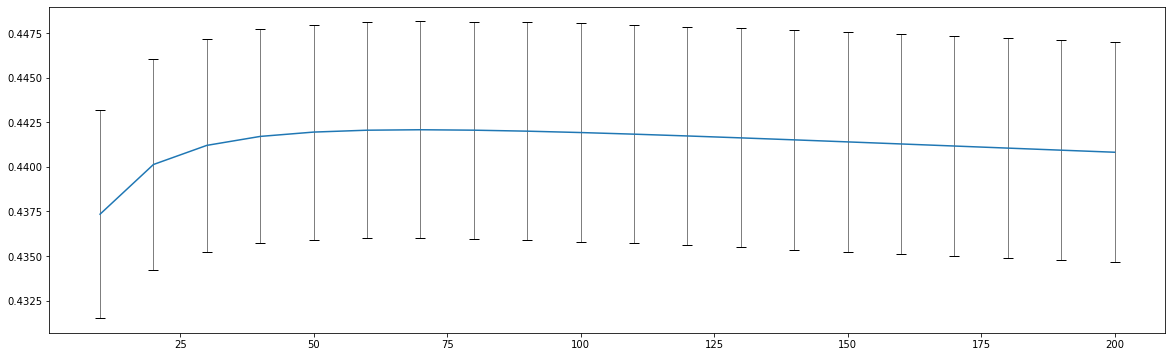

In [207]:
plt.figure(figsize=(20,6))
plt.errorbar(np.arange(10,210,10), regr.cv_results_['mean_test_score'],
             yerr=regr.cv_results_['std_test_score'], ecolor='k', elinewidth=0.5, capsize=5)

In [210]:
def get_Kaggle_submission(y_top_20):
    """Get data in Kaggle submission format
    
    Parameters
    ----------
    y_top_20: ndarray of shape (n, 20)
        A list of top 20 IDs lists that match each of the n descriptions. 
        
    Returns
    -------
    df: pandas.DataFrame
        Dataframe with columns and values that map correctly to Kaggle's expected submission format.
    """
    d = {
        "Description_ID": [f"{i}.txt" for i in range(len(y_top_20))],
        "Top_20_Image_IDs": [" ".join(
            [f"{j}.jpg" for j in y_top_20[i]]
        ) for i in range(len(y_top_20))]
    }
    return pd.DataFrame(d)

In [244]:
df_submit = get_Kaggle_submission(Y_test_top_20)
df_submit.head(10)

,Description_ID,Top_20_Image_IDs
0,0.txt,124.jpg 1480.jpg 231.jpg 345.jpg 1011.jpg 1077...
1,1.txt,833.jpg 331.jpg 169.jpg 1742.jpg 314.jpg 80.jp...
2,2.txt,1724.jpg 1183.jpg 838.jpg 159.jpg 1840.jpg 598...
3,3.txt,1514.jpg 469.jpg 1315.jpg 1035.jpg 1024.jpg 17...
4,4.txt,1561.jpg 742.jpg 985.jpg 1564.jpg 1269.jpg 942...
5,5.txt,492.jpg 771.jpg 1335.jpg 1693.jpg 630.jpg 1943...
6,6.txt,1855.jpg 1660.jpg 1216.jpg 429.jpg 582.jpg 170...
7,7.txt,1900.jpg 975.jpg 528.jpg 409.jpg 1270.jpg 168....
8,8.txt,727.jpg 1283.jpg 719.jpg 419.jpg 531.jpg 103.j...
9,9.txt,770.jpg 554.jpg 965.jpg 614.jpg 1818.jpg 413.j...


In [238]:
# Write to file
df_submit.to_csv("my_submission.csv", index=False)

Two giraffes are in a background of tall trees  these are two tall giraffes eating from trees The two giraffes are standing next to each other   The baby giraffe is stretching it's neck to look at mama  Two giraffes standing in front of several trees  


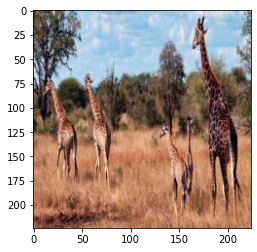

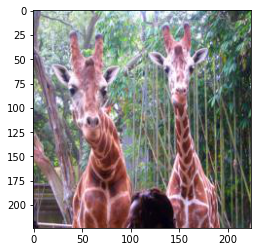

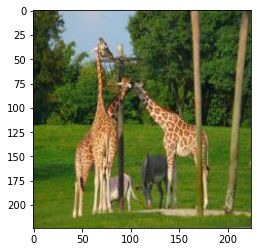

A young man riding a skateboard in a parking lot  A man holding onto a pipe with his hand out in a parking lot  a man holding onto a rail in the middle of an empty parking lot A man in an empty parking lot trying to pull something a man is in the parking lot doing a pose of some sort 


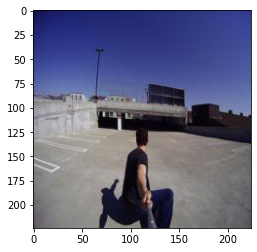

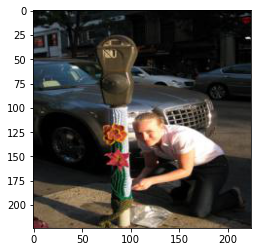

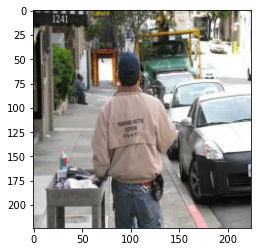

A photo of a dining venue outside complete with tables, chairs and umbrellas  Tables and chairs in a patio area to eat  A patio filled with white tables and chairs covered with umbrellas  outdoor patio for guest seating at a restaurant An empty dining area features round tables with several umbrellas and red and green backed chairs  


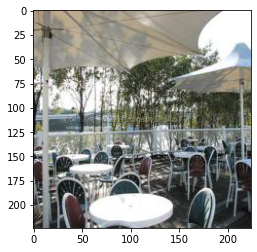

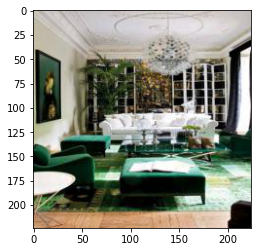

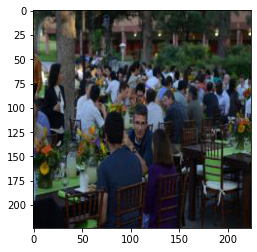

In [261]:
rand_index = np.random.randint(0, 2000, 3)
for i in rand_index:
    print(test_desc[i])
    top_images = df_submit.iloc[i]['Top_20_Image_IDs'].split()[:3]
    for image in top_images:
        imageID = int(image.split('.jpg')[0])
        show_image(imageID, train_set=False)